### Introduction
Metabolic dysfunction-associated steatotic liver disease (MASLD) progresses to metabolic dysfunction-associated steatohepatitis (MASH) and is a major cause of liver cirrhosis.

To objectively evaluate histological disease activity, the NAFLD Activity Score (NAS) is widely used. NAS is a semiquantitative scoring system ranging from 0 to 8, combining assessments of steatosis (0–3), lobular inflammation (0–3), and hepatocyte ballooning (0–2). Higher NAS scores indicate more severe liver inflammation and injury, and are commonly used to stage MASLD/MASH progression.

While intrahepatic immune mechanisms have been relatively well studied, the landscape and functional state of peripheral blood immune cells remain largely unexplored in MASLD/MASH. Understanding these circulating immune signatures may uncover systemic immune dysregulation and reveal potential non-invasive biomarkers or therapeutic targets.

Thus, this notebook addresses the following questions:
1. How does the composition of peripheral immune cell types vary across disease stages (e.g., Control, Low NAS, Medium NAS, High NAS)?
2. Which genes are differentially expressed according to different NAS stages?

dataset:https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE267033

paper: https://doi.org/10.1097/HC9.0000000000000643

In [1]:
#import packages
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
expr = pd.read_csv("GSE267033_counts_RNAseq_sc_WBC.txt", sep=' ')
obs = pd.read_csv('GSE267033_metadata_RNAseq_sc_WBC.txt',sep=' ')

In [3]:
adata = sc.AnnData(X=expr.T, obs=obs, var=pd.DataFrame(index=expr.index))
adata.write("WBC.h5ad")

### Preprocessing - quality control
Few detected genes, low count depth, and a high fraction of mitochondrial counts are indicative of cells whose cytoplasmic mRNA has leaked out through a broken membrane. Thus, they have to be filter out.


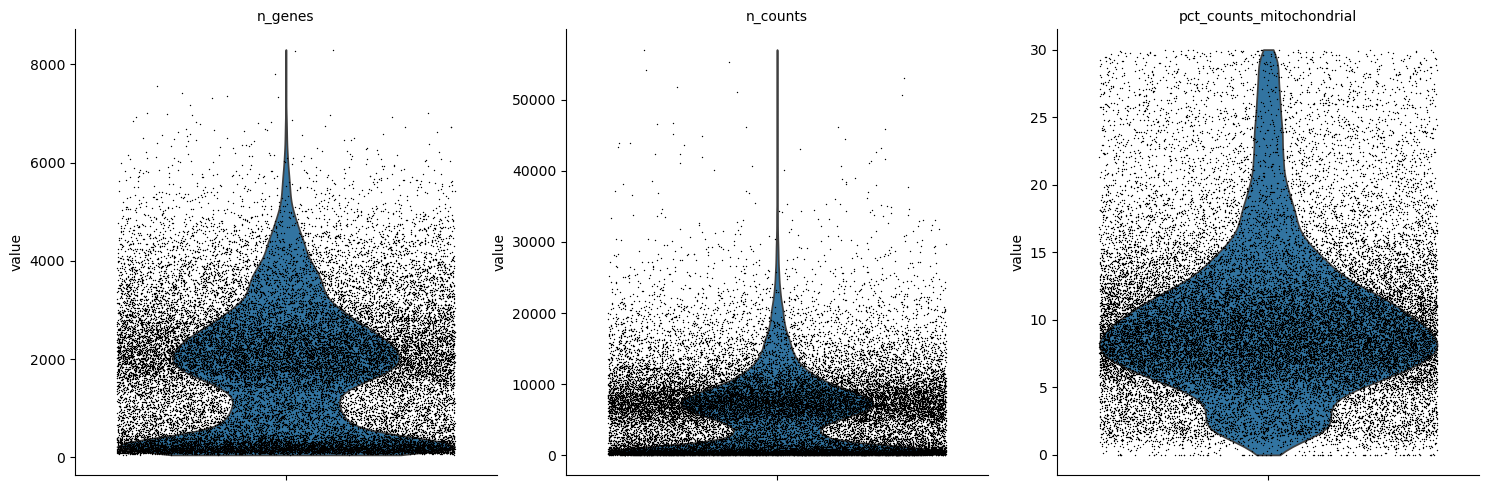

In [4]:
#quality control
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.violin(adata, ["n_genes", "n_counts", "pct_counts_mitochondrial"], jitter=0.4, multi_panel=True)

From the above plot, we can find that the threshold for genes is 500, for counts is 1000, for pct_counts_mitochondrial is 20.

In [6]:
#filter cells according to identified QC thresholds
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mitochondrial'] < 20]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 29890
Number of cells after gene filter: 22627
Number of cells after min count filter: 22236
Number of cells after MT filter: 21851


In [7]:
#filter genes
print('Total number of genes: {:d}'.format(adata.n_vars))

# min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 58051


/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Number of genes after cell filter: 24322


In [8]:
adata.write("processed_WBC.h5ad")

### Normalization

In [9]:
scales_counts = sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

### Identify highly variable genes
We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes.

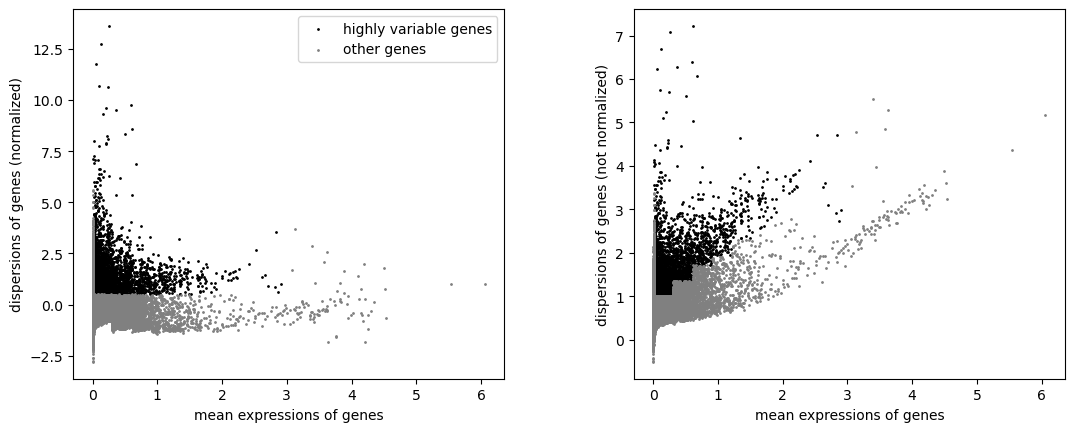

In [10]:
sc.pp.highly_variable_genes(
    adata, min_mean=0.0125, max_mean=3, min_disp=0.5, layer="log1p_norm"
)
sc.pl.highly_variable_genes(adata)

We can do a brief counting to see how many genes have been marked as highly variable (True means highly variable, False means otherwise). We can see we will retain 3831 genes for downstream analysis.

In [11]:
print(adata.var.highly_variable.value_counts())

highly_variable
False    20491
True      3831
Name: count, dtype: int64


### Visualization

#### PCA & UMAP

In [13]:
adata

AnnData object with n_obs × n_vars = 21851 × 24322
    obs: 'n_genes', 'n_counts', 'pct_counts_mitochondrial', 'pct_counts_ribosomal', 'gender', 'leiden', 'cell.type', 'NAS_group', 'NAS', 'Control_MAFLD', 'sampleID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm'
    obsp: 'distances', 'connectivities'

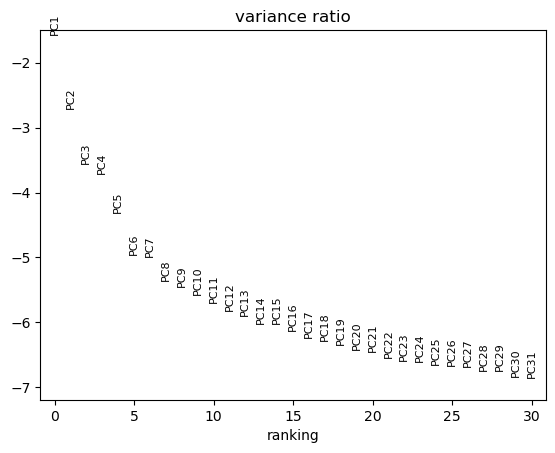

In [ ]:
adata.X = adata.layers['log1p_norm']
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata)

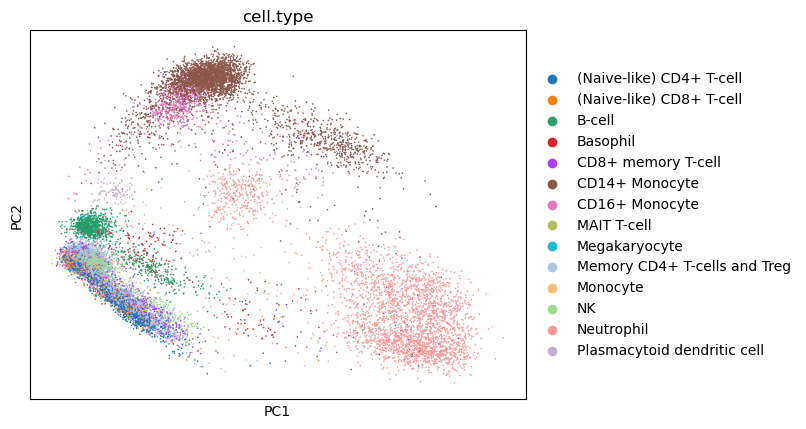

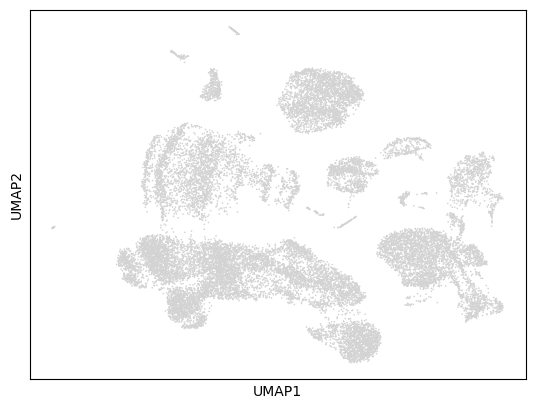

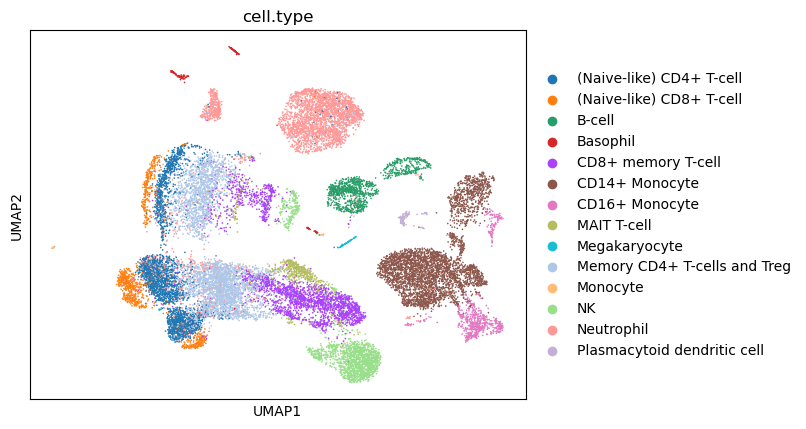

In [17]:
sc.pl.pca_scatter(adata, color='cell.type')
sc.pl.umap(adata)
sc.pl.umap(adata, color='cell.type')

### Find highly expressed genes in each cluster

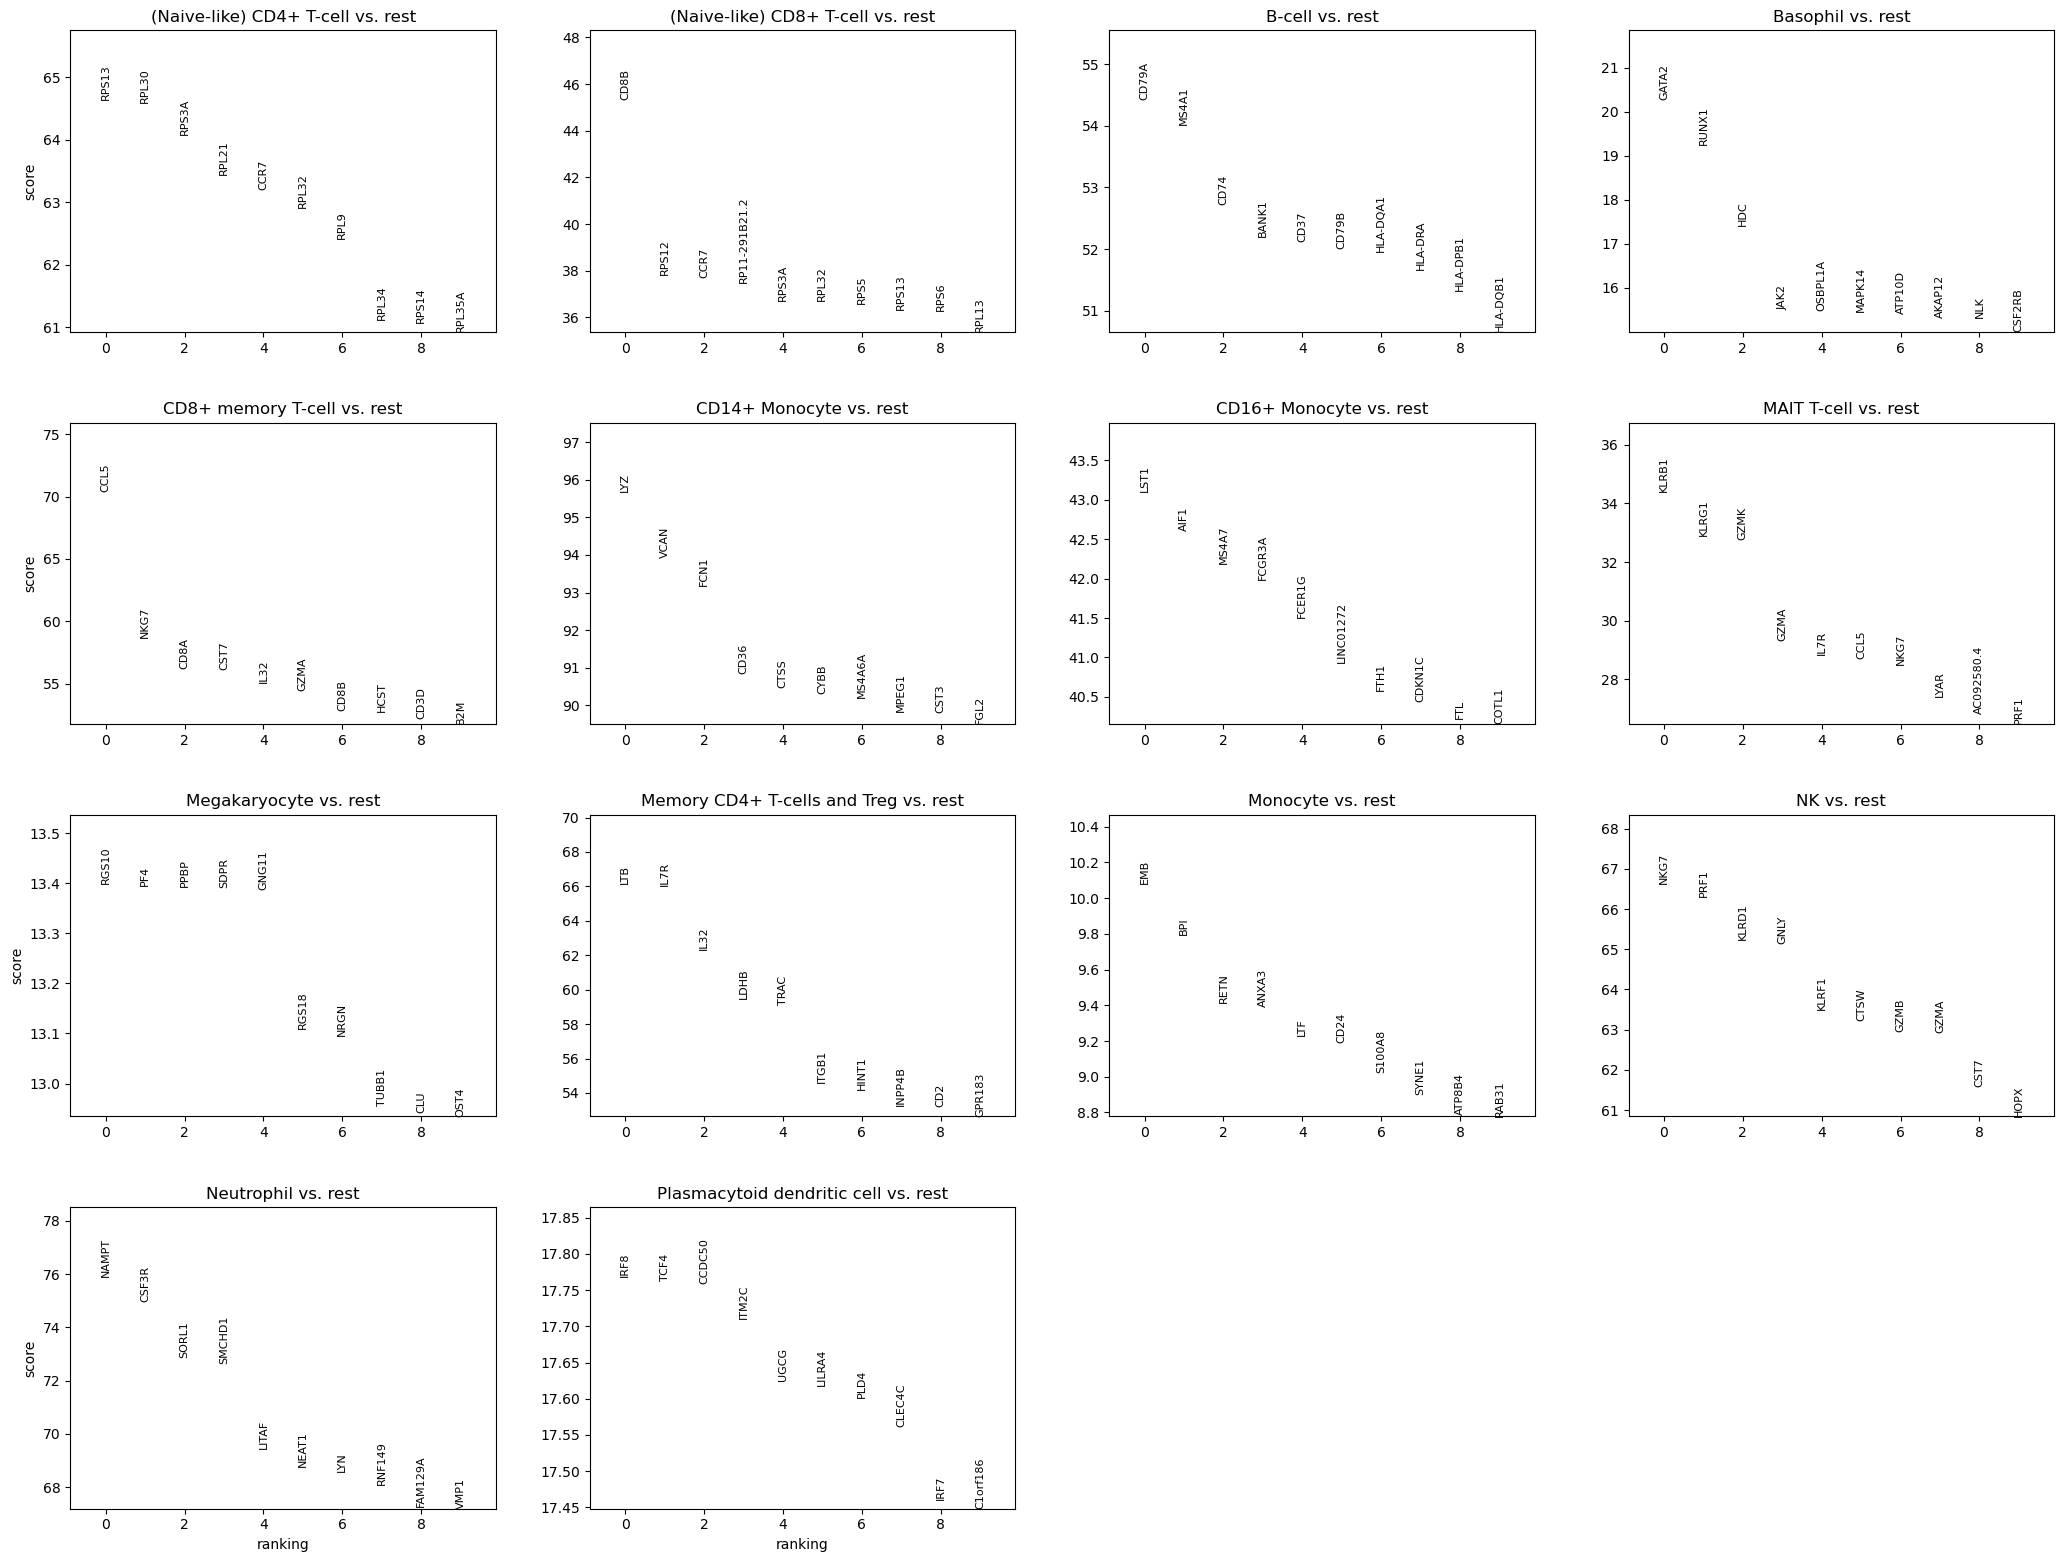

In [19]:
sc.tl.rank_genes_groups(adata, groupby='cell.type', method = 'wilcoxon', key_added='wilcoxon_cluster_cell_type')
sc.pl.rank_genes_groups(
    adata,
    n_genes=10,
    sharey=False,
    key="wilcoxon_cluster_cell_type",
)

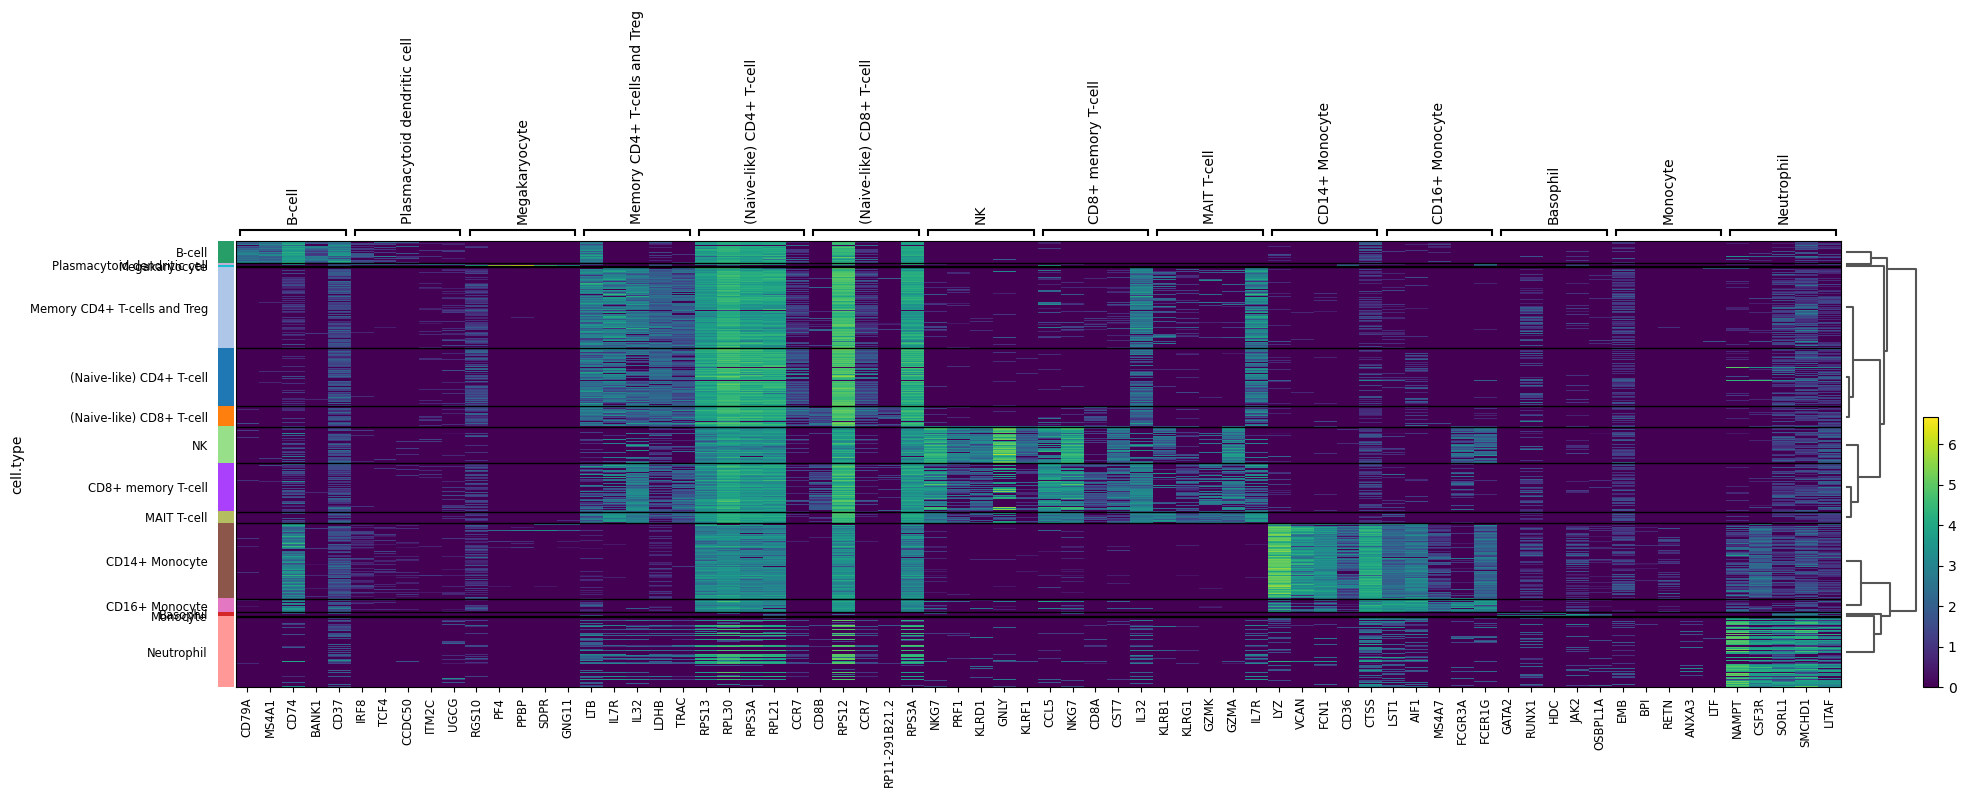

In [20]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    key="wilcoxon_cluster_cell_type",
    groupby="cell.type",
    show_gene_labels=True,
)

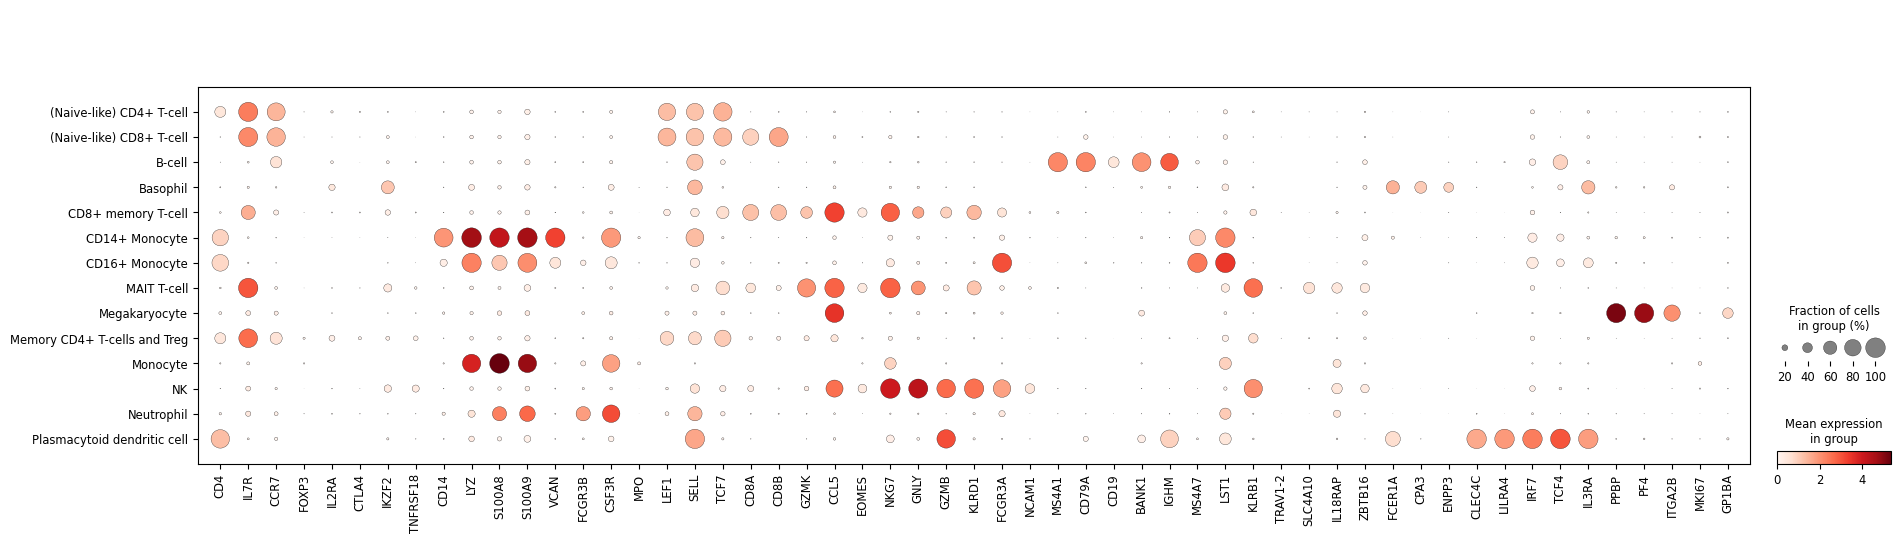

In [30]:
marker_genes = [
    "CD4", "IL7R", "CCR7", "FOXP3", "IL2RA", "CTLA4", "IKZF2", "TNFRSF18",
    "CD14", "LYZ", "S100A8", "S100A9", "VCAN", "FCGR3B", "CSF3R", "MPO", "LEF1", "SELL",
    "TCF7", "CD8A", "CD8B", "GZMK", "CCL5", "EOMES", "NKG7", "GNLY", "GZMB", "KLRD1",
    "FCGR3A", "NCAM1", "MS4A1", "CD79A", "CD19", "BANK1", "IGHM", "MS4A7", "LST1",
    "KLRB1", "TRAV1-2", "SLC4A10", "IL18RAP", "ZBTB16", "FCER1A", "CPA3", "ENPP3", 
    "CLEC4C", "LILRA4", "IRF7", "TCF4", "IL3RA", "PPBP", "PF4",
    "ITGA2B", "MKI67", "GP1BA"
]

sc.pl.dotplot(adata, marker_genes, groupby="cell.type")


### Cell type composition across NAS stage

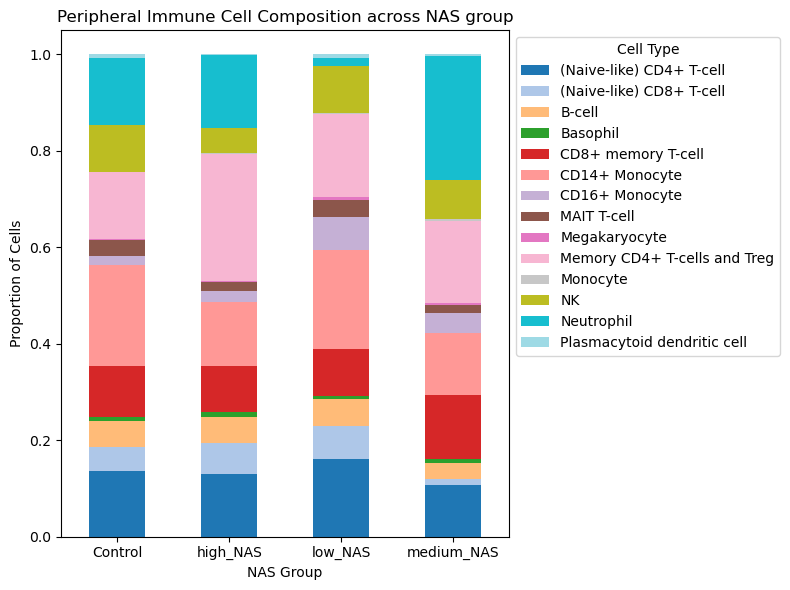

In [68]:
composition = pd.crosstab(adata.obs['NAS_group'], adata.obs['cell.type'], normalize='index')
composition.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,6))
plt.title('Peripheral Immune Cell Composition across NAS group')
plt.ylabel('Proportion of Cells')
plt.xlabel('NAS Group')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1, 1), title='Cell Type')
plt.tight_layout()
plt.show()

From the figure, we can observe:
- Control group is mainly composed of CD14+ monocyte, Naive-like CD4+ T-cell, memory CD4+ T-cells and Treg.
- High_NAS group has highest memory CD4+ T-cells and Treg proportion and lowest NK cell proportion.
- Low_NAS group has highest monocyte proportion and lowest neutrophil proportion.
- Medium_NAS group has highest neutrophil proportion and lowest Naive-like CD8+ T-cell.

### Differential expression analysis across NAS stage

There are four groups in this dataset: control, low_NAS (NAS between 0 to 2), medium_NAS (NAS between 3 to 4), high_NAS (NAS between 5 to 8).

We'd like to investigate the differential gene expression between different NAS groups.

In [57]:
sc.tl.rank_genes_groups(
    adata,
    groupby='NAS_group',
    method='wilcoxon',
    key_added='rank_genes_by_NAS'
)


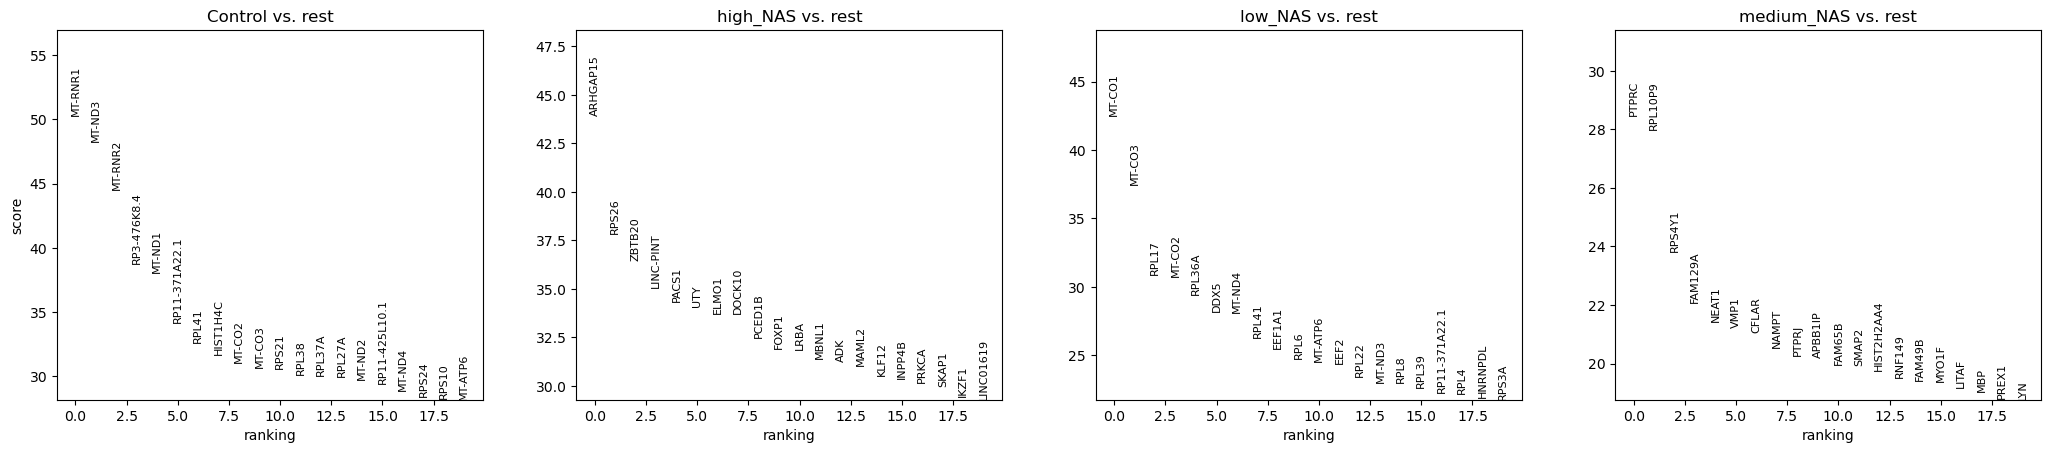

In [58]:
sc.pl.rank_genes_groups(
    adata,
    key="rank_genes_by_NAS",
    n_genes=20,
    sharey=False
)

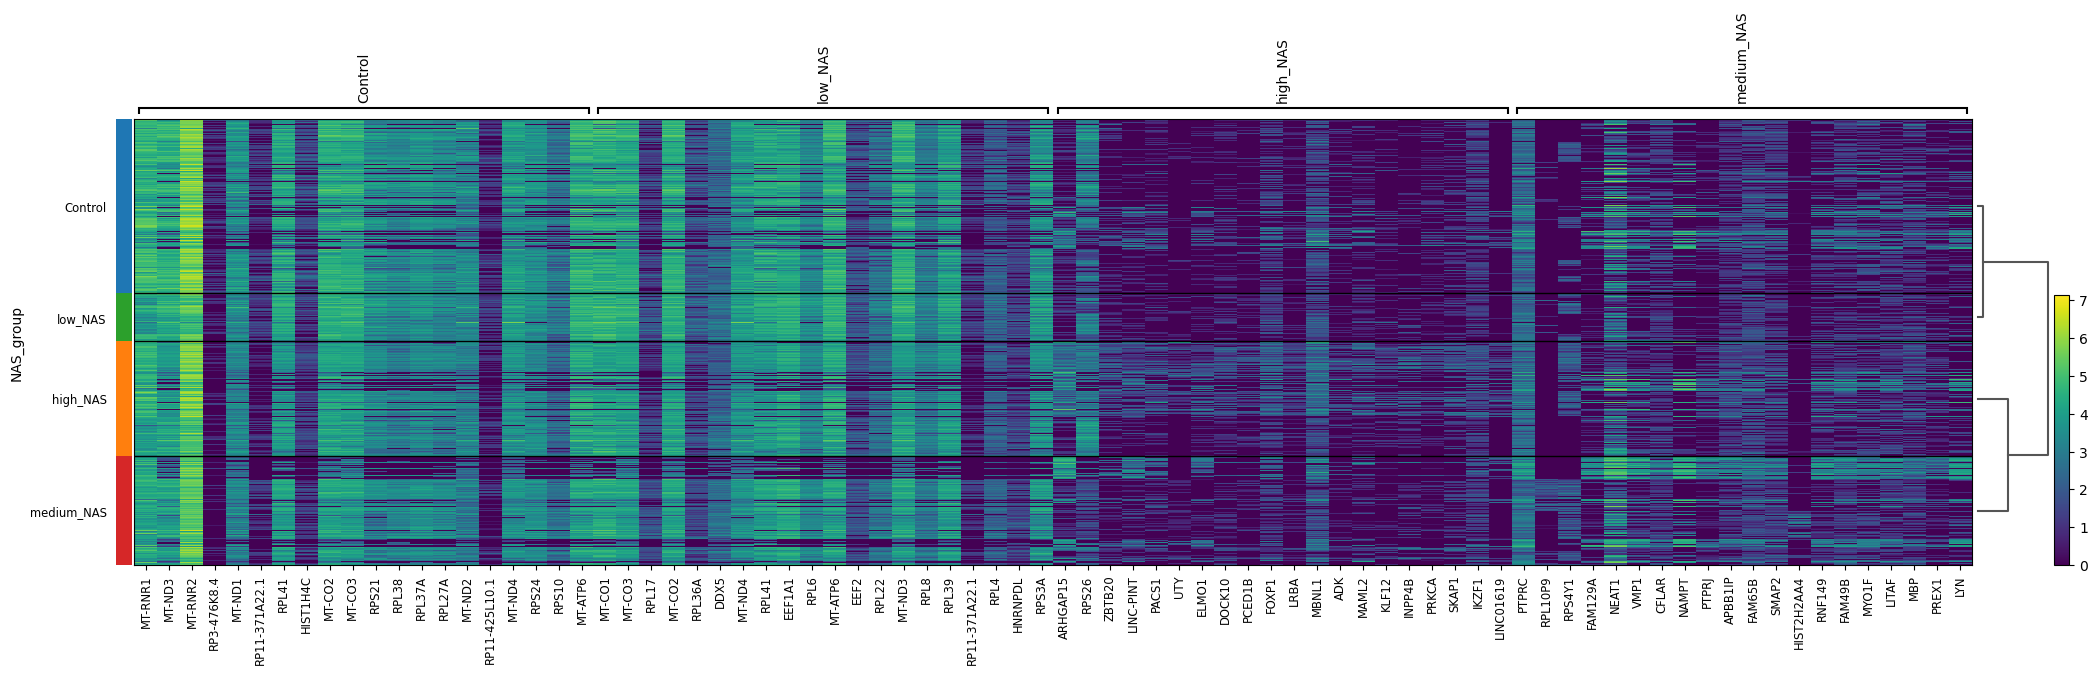

In [59]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=20, groupby='NAS_group', key="rank_genes_by_NAS", show_gene_labels=True)


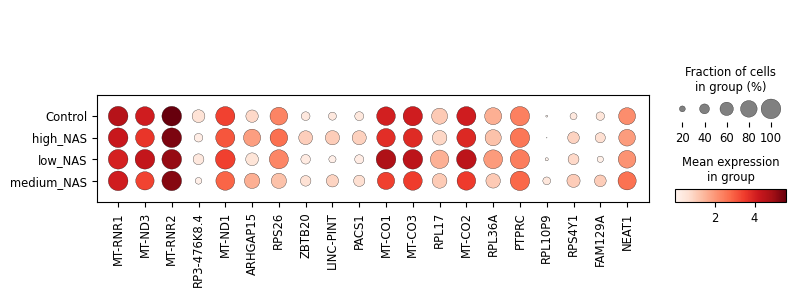

In [ ]:
top_genes = []
for group in adata.uns['rank_genes_by_NAS']['names'].dtype.names:
    top_genes.extend(adata.uns['rank_genes_by_NAS']['names'][group][:5].tolist())
top_genes = list(dict.fromkeys(top_genes))  # remove duplicate genes
sc.pl.dotplot(adata, top_genes, groupby='NAS_group', show=True)

### Discusions and conclusions
- MASLD disease activity correlates with major shifts in immune cell populations.

- Specific inflammatory gene signatures emerge with high NAS.

- Peripheral blood may offer insight into liver pathology progression.